Here, we look at particle orbits in a tokamak configuration. I'm using a polynomial solution to the grad-shafranov equation, which describes the magnetic field of a tokamak.

Here, I'm just defining what the grad-shafranov equation is and the soloviev solution to that PDE, which is the flux function $\Psi$. The parameters here are chosen to be similar to LTX, which is a tokamak at PPPL.

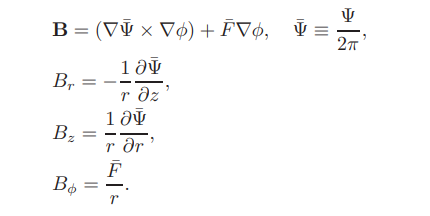

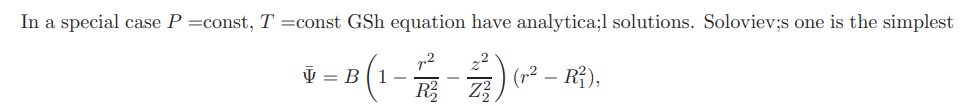

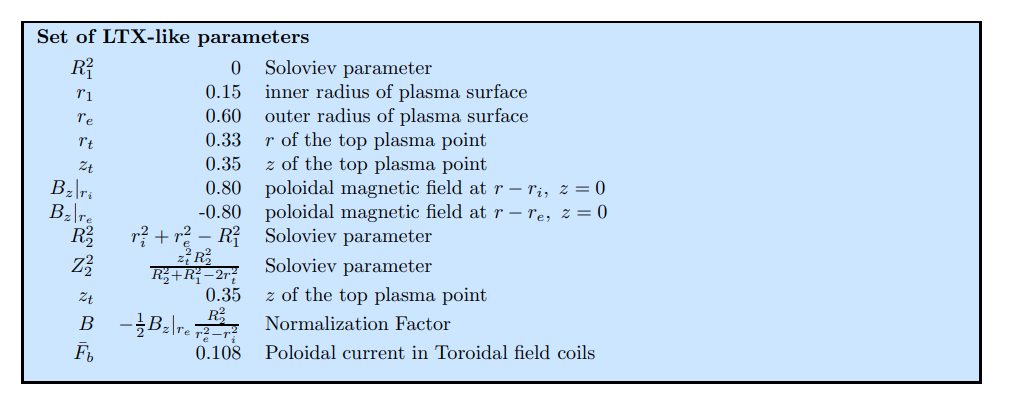

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def Soloviev(r,z):
    psi = B_norm*(1-((r/R2)**2)-((z/Z2)**2))*((r**2) - (R1**2))
    return psi

def get_B(r,z):
    dpsidz = B_norm*(-2*z / Z2**2) * (r**2 + R1**2)
    dpsidr = B_norm*2*r*(1 + (R1/R2)**2 - (2*r**2/R2**2) - (z/Z2)**2 ) 
    Br = - 1/r * dpsidz
    Bz =   1/r * dpsidr
    Bphi = F_mag / r
    return Br, Bz, Bphi

global R1,r2,re,rt,zt,R2,Z2,B_norm,F_mag
R1 = 0 #Soloviev Parameter
ri = 0.15 #inner radius of plasma surface
re = 0.6 #outer radius of plasma surface
rt = 0.33 #r at the top plasma point
zt = 0.35 #z at the top plasma point
R2 = np.sqrt(ri**2 + re**2 - R1**2)
Z2 = np.sqrt((zt**2 * R2**2)/(R2**2 + R1**2 - 2*rt**2))
Bz_ri =  0.8 #Poloidal magnetic field at r-ri, z=0
Bz_re = -0.8 #Poloidal magnetic field at r-re, z=0
B_norm = -1/2 * Bz_re * (R2**2)/(re**2 - ri**2)
F_mag = .108 # Poloidal current in Toroidal field coils
n = 5 #order of chebyshev representation


Here, I plot the flux function we define above

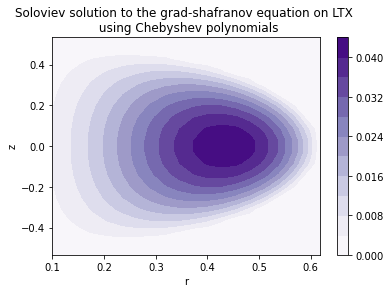

In [ ]:
npts_1d = 20
rvals = np.linspace(0.1,R2,npts_1d)
zvals = np.linspace(-Z2,Z2,npts_1d)
gridPTS = np.meshgrid(rvals,zvals)
solnGrid = np.zeros([len(rvals),len(zvals)])
for ir in range(len(rvals)):
    for iz in range(len(zvals)):
        solnGrid[ir,iz] = Soloviev(gridPTS[0][ir,iz], gridPTS[1][ir,iz])
        
solnGrid[solnGrid<0]=0
plt.contourf(rvals,zvals,solnGrid,10, cmap='Purples')
plt.xlabel('r')
plt.ylabel('z')
plt.colorbar()
plt.title('Soloviev solution to the grad-shafranov equation on LTX \n using Chebyshev polynomials')
plt.show()

Let's plot the z, r and phi components of magnetic field using the same technique

In [ ]:
gridPTS = np.meshgrid(rvals,zvals)
Br_grid = np.zeros([len(rvals),len(zvals)])
Bz_grid = np.zeros([len(rvals),len(zvals)])
Bphi_grid = np.zeros([len(rvals),len(zvals)])

for ir in range(len(rvals)):
    for iz in range(len(zvals)):
        Br_grid[ir,iz], Bz_grid[ir,iz], Bphi_grid[ir,iz] = get_B(gridPTS[0][ir,iz], gridPTS[1][ir,iz])

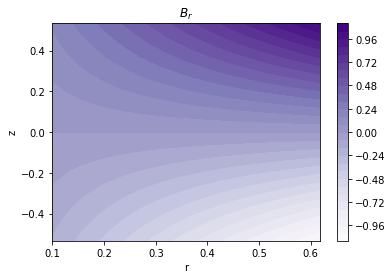

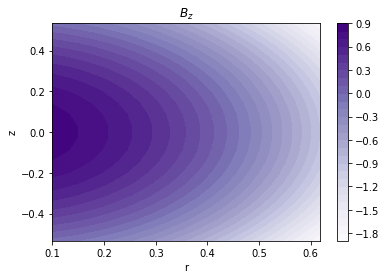

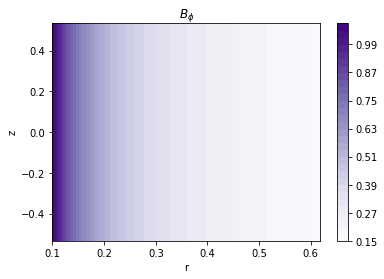

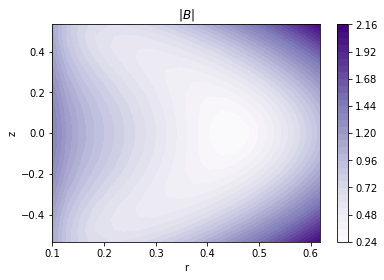

In [ ]:
plt.contourf(rvals,zvals,Br_grid,30, cmap='Purples')
plt.xlabel('r')
plt.ylabel('z')
plt.colorbar()
plt.title('$B_r$')
plt.show()

plt.contourf(rvals,zvals,Bz_grid,30, cmap='Purples')
plt.xlabel('r')
plt.ylabel('z')
plt.colorbar()
plt.title('$B_z$')
plt.show()

plt.contourf(rvals,zvals,Bphi_grid,30, cmap='Purples')
plt.xlabel('r')
plt.ylabel('z')
plt.colorbar()
plt.title('$B_\phi$')
plt.show()

Bmag_grid = np.sqrt(Bphi_grid**2 + Bz_grid**2 + Br_grid**2)
plt.contourf(rvals,zvals,Bmag_grid, 30, cmap='Purples')
plt.xlabel('r')
plt.ylabel('z')
plt.colorbar()
#plt.xlim([0.25,.6])
plt.title('$|B|$')
plt.show()

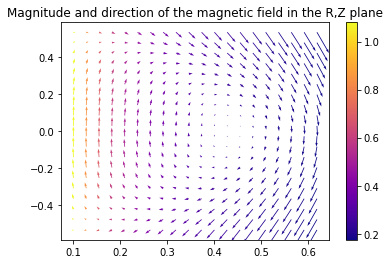

In [ ]:
rgrid_mesh = np.tile(rvals,(npts_1d,1))
zgrid_mesh = np.transpose(np.tile(zvals,(npts_1d,1)))

plt.quiver(rgrid_mesh, zgrid_mesh, Br_grid, Bz_grid, Bphi_grid, cmap='plasma')
plt.title('Magnitude and direction of the magnetic field in the R,Z plane')
plt.colorbar()

Next, we will work on a particle pusher for pushing particles in the magnetic field. Let's start with Euler's method for particle pushing

<function matplotlib.pyplot.show>

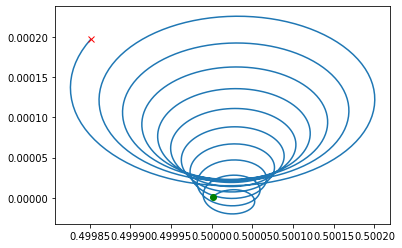

In [ ]:
q_e = 1.6e-19
m = 1.67e-27 # proton
m = 9.11e-31 # electron
global qdivm
qdivm = q_e/m
x0 = np.array([0.5, 0, 0])
v0 = np.array([1e6, 1e6, 1e6]) #R, Z, phi

dtfrac = 100
n_steps = 10*dtfrac

v_track = np.zeros((3,n_steps))
x_track = v_track
B = np.zeros(3)

v = v0
x = x0
for ixt in range(n_steps):
    B[0], B[1], B[2] = get_B(x[0],x[1])
    omega_B = qdivm * np.linalg.norm(B)
    dt = (2*np.pi/omega_B) / dtfrac

    a = qdivm*np.cross(v,B)

    x = x + dt * v
    v = v + dt * a
    
    v_track[:,ixt] = v[:]
    x_track[:,ixt] = x[:]


plt.plot(x_track[0,:],x_track[1,:])
plt.plot(x_track[0,-1], x_track[1,-1], 'rx')
plt.plot(x_track[0,0], x_track[1,0], 'go')
plt.show

Clearly, with the energy losses due to Euler's method, they occur on a time scale much faster than the cyclotron frequency. We need a better numerical technique with less energy loss. Boris's method is well known for perserving energy conservation for orbital motion.

<function matplotlib.pyplot.show>

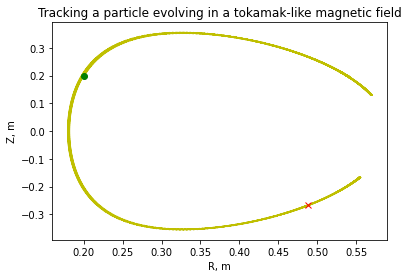

In [ ]:
def Boris(x0, v0, dt, B):
    t = qdivm * dt * B / 2
    v1 = v0 + np.cross(v0, t)
    v0 += np.cross(v1, 2 /(1 + np.abs(t)**2) * t)
    x0 += dt * v0
    return x0, v0

#Control larmor radius and set qdivm to match

#x0 = np.array([0.473, .194, -.24]) v0 = np.array([0e5, 0, 1e5]) #R, Z, phi
#Good parameters for a banana with open to the right x0 = np.array([0.2, .2, 0]) 
#v0 = np.array([0e5, 0, 1e5]) #R, Z, phi
x0 = np.array([0.2, .2, 0]) 

B[0], B[1], B[2] = get_B(x0[0],x0[1])
v_hat = np.array([0,10,1])
v_hat = v_hat/np.linalg.norm(v_hat)

v0 = v_hat * 1e7
dtfrac = 100
n_steps = 2000 * dtfrac

v_track = np.zeros((3,n_steps))
x_track = v_track

v = v0
x = x0

ixt = 0
exit_step = 0
while (ixt<n_steps):
    B[0], B[1], B[2] = get_B(x[0],x[1])
    omega_B = qdivm * np.linalg.norm(B)
    dt = (2*np.pi/omega_B) / dtfrac

    x, v = Boris(x,v,dt,B)
    
    v_track[:,ixt] = v[:]
    x_track[:,ixt] = x[:]
    psi = Soloviev(x[0],x[1])
    if (psi>0):
        ixt += 1
    else:
        exit_step = ixt
        ixt = n_steps+1

if (exit_step==0):
    exit_step = ixt
else:
    ixt = exit_step

plt.plot(x_track[0,0:exit_step],x_track[1,0:exit_step],'y')
if (exit_step != 0):
    plt.plot(x_track[0,exit_step-1], x_track[1,exit_step-1], 'rx')
    plt.plot(x_track[0,0], x_track[1,0], 'go')

plt.xlabel('R, m')
plt.ylabel('Z, m')
plt.title('Tracking a particle evolving in a tokamak-like magnetic field')
plt.show

<function matplotlib.pyplot.show>

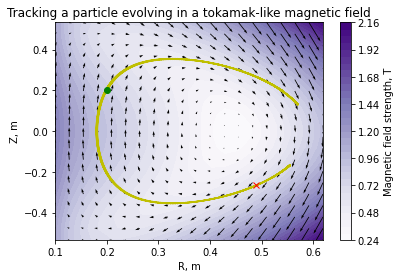

In [ ]:
plt.plot(x_track[0,0:exit_step],x_track[1,0:exit_step],'y')
if (exit_step != 0):
    plt.plot(x_track[0,exit_step-1], x_track[1,exit_step-1], 'rx')
    plt.plot(x_track[0,0], x_track[1,0], 'go')

plotcontour = plt.contourf(rvals,zvals,Bmag_grid, 30, cmap='Purples')
plt.quiver(rgrid_mesh, zgrid_mesh, Br_grid, Bz_grid)
plt.xlabel('R, m')
plt.ylabel('Z, m')
plt.title('Tracking a particle evolving in a tokamak-like magnetic field')
plt.colorbar(plotcontour, label='Magnetic field strength, T')
plt.show

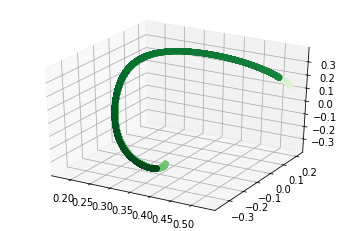

In [ ]:
ax = plt.axes(projection='3d')
# Convert to cartesian
x_track_cart = np.zeros((3,exit_step))
x_track_cart[0,:] = x_track[0,0:exit_step] * np.cos(x_track[2,0:exit_step])
x_track_cart[1,:] = x_track[0,0:exit_step] * np.sin(x_track[2,0:exit_step])
x_track_cart[2,:] = x_track[1,0:exit_step]
# Data for a three-dimensional line
time1d = np.arange(0,exit_step,1)
ax.scatter(x_track_cart[0,:], x_track_cart[1,:], x_track_cart[2,:], c=time1d, cmap='Greens')
#ax.plot3D(x_track_cart[0,:], x_track_cart[1,:], x_track_cart[2,:], animated=True)